In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
ori = np.load('../../OUTPUT/toyexample/origin_data_unnorm_toyexample.npy')
gen = np.load('../../OUTPUT/toyexample/generate_data_unnorm_toyexample.npy')

## Extreme Analysis

In [3]:
import numpy as np


def _fit_trend_and_residual(y):
    y = y.astype(np.float32)
    T = len(y)
    t = np.arange(T, dtype=np.float32)
    A = np.c_[t, np.ones_like(t)]
    slope, intercept = np.linalg.lstsq(A, y, rcond=None)[0]
    trend = slope * t + intercept
    return y - trend

def _remove_bins_via_fft(r, bins=(5, 8, 11)):
    T = len(r)
    spec = np.fft.rfft(r)
    spec[list(bins)] = 0
    return np.fft.irfft(spec, n=T).astype(np.float32)

def extreme_residual(y, season_bins=(5, 8, 11)):
    r = _fit_trend_and_residual(y)
    r_ex = _remove_bins_via_fft(r, bins=season_bins)
    return r_ex

def _zero_crossings(x):
    x = x.astype(np.float32)
    return int(np.sum((x[:-1] * x[1:]) < 0))


## time domain
def extreme_time_metrics(y, t0=120, w=6, season_bins=(5, 8, 11)):
    r = extreme_residual(y, season_bins=season_bins)
    T = len(r)

    L = max(0, t0 - w)
    R = min(T, t0 + w + 1)

    win = r[L:R]
    out = np.concatenate([r[:L], r[R:]], axis=0)

    E_in = float(np.mean(win**2))
    A_in = float(np.max(np.abs(win)))
    A_out = float(np.max(np.abs(out))) if len(out) > 0 else 0.0
    SNR = A_in / (A_out + 1e-12)

    return {"E_in": E_in, "A_in": A_in, "A_out": A_out, "SNR": float(SNR)}

## Frequency Domain
def extreme_freq_metrics(y, ke=20, band_half_width=2, season_bins=(5, 8, 11)):
    r = extreme_residual(y, season_bins=season_bins)

    spec = np.fft.rfft(r)
    power = (np.abs(spec) ** 2).astype(np.float32)
    power[0] = 0.0

    kmax = len(power) - 1
    kL = max(1, ke - band_half_width)
    kR = min(kmax, ke + band_half_width)

    band_energy = float(power[kL:kR+1].sum())
    total_energy = float(power.sum())
    band_ratio = band_energy / (total_energy + 1e-12)

    peak_bin = int(np.argmax(power))
    hit = int(kL <= peak_bin <= kR)

    return {"band_ratio": float(band_ratio), "peak_bin": peak_bin, "hit": float(hit)}

## shape
def extreme_shape_metrics(y, t0=120, w=6, season_bins=(5, 8, 11)):
    """
    基于 toy 设定的“形状”自检：
      - loc_ratio: 事件窗口能量 / 全局能量 （越大说明越集中在 t0）
      - peak_offset: 最大绝对值位置距 t0 的偏移（越小越好）
      - zc_in: 事件窗口过零次数（反映振荡性）
      - zc_out: 窗口外过零次数（噪声一般也会过零，但幅值应小）
      - amp_ratio: 事件窗口峰值 / 窗口外峰值（越大越像“局部 burst”而不是到处高频）
    """
    r = extreme_residual(y, season_bins=season_bins)
    T = len(r)

    L = max(0, t0 - w)
    R = min(T, t0 + w + 1)

    win = r[L:R]
    out = np.concatenate([r[:L], r[R:]], axis=0)

    E_win = float(np.sum(win**2))
    E_all = float(np.sum(r**2))
    loc_ratio = E_win / (E_all + 1e-12)

    # burst 应该在 t0 附近达到最大幅值
    peak_idx = int(np.argmax(np.abs(r)))
    peak_offset = abs(peak_idx - t0)

    zc_in = _zero_crossings(win)
    zc_out = _zero_crossings(out) if len(out) > 1 else 0

    A_in = float(np.max(np.abs(win)))
    A_out = float(np.max(np.abs(out))) if len(out) > 0 else 0.0
    amp_ratio = A_in / (A_out + 1e-12)

    return {
        "loc_ratio": float(loc_ratio),
        "peak_offset": float(peak_offset),
        "zc_in": float(zc_in),
        "zc_out": float(zc_out),
        "amp_ratio": float(amp_ratio),
    }

## whole function
def compute_extreme_metrics_dataset(
    X,
    t0=120, w=6,
    ke=20, band_half_width=2,
    season_bins=(5, 8, 11),
):
    N, T, C = X.shape
    out_time, out_freq, out_shape = [], [], []

    for i in range(N):
        y = X[i, :, 0]
        out_time.append(extreme_time_metrics(y, t0=t0, w=w, season_bins=season_bins))
        out_freq.append(extreme_freq_metrics(y, ke=ke, band_half_width=band_half_width, season_bins=season_bins))
        out_shape.append(extreme_shape_metrics(y, t0=t0, w=w, season_bins=season_bins))

    return out_time, out_freq, out_shape

def print_metrics_summary(out_time, out_freq, out_shape):
    def _summarize(list_of_dicts, title, custom=None):
        if (list_of_dicts is None) or (len(list_of_dicts) == 0):
            print(f"\n{title}: (empty)")
            return

        print(f"\n{title}")
        keys = list(list_of_dicts[0].keys())

        for k in keys:
            vals = np.array([d[k] for d in list_of_dicts], dtype=np.float32)

            if custom == "freq" and k == "peak_bin":
                q10, q50, q90 = np.quantile(vals, [0.1, 0.5, 0.9])
                print(f"  {k}: median={q50:.0f}, q10={q10:.0f}, q90={q90:.0f}, min={vals.min():.0f}, max={vals.max():.0f}")
            elif custom == "freq" and k == "hit":
                print(f"  {k}: rate={vals.mean():.6f}  (min={vals.min():.0f}, max={vals.max():.0f})")
            else:
                print(f"  {k}: mean={vals.mean():.6f}, min={vals.min():.6f}, max={vals.max():.6f}")

    _summarize(out_time,  "Time-domain metrics")
    _summarize(out_freq,  "Freq-domain metrics", custom="freq")
    _summarize(out_shape, "Shape metrics")

In [4]:
out_time_ori, out_freq_ori, out_shape_ori = compute_extreme_metrics_dataset(ori)
print_metrics_summary(out_time_ori, out_freq_ori, out_shape_ori)


Time-domain metrics
  E_in: mean=0.083766, min=0.000357, max=2.436764
  A_in: mean=0.443364, min=0.030504, max=3.798393
  A_out: mean=2.116832, min=0.136946, max=3.968185
  SNR: mean=0.320720, min=0.009396, max=13.992218

Freq-domain metrics
  band_ratio: mean=0.089646, min=0.001001, max=0.220714
  peak_bin: median=3, q10=3, q90=4, min=1, max=100
  hit: rate=0.020700  (min=0, max=1)

Shape metrics
  loc_ratio: mean=0.065787, min=0.000306, max=0.893301
  peak_offset: mean=51.344799, min=0.000000, max=120.000000
  zc_in: mean=1.344500, min=0.000000, max=11.000000
  zc_out: mean=21.041800, min=6.000000, max=59.000000
  amp_ratio: mean=0.320720, min=0.009396, max=13.992218


In [5]:
out_time_gen, out_freq_gen, out_shape_gen = compute_extreme_metrics_dataset(gen)
print_metrics_summary(out_time_gen, out_freq_gen, out_shape_gen)


Time-domain metrics
  E_in: mean=0.013924, min=0.000302, max=0.063644
  A_in: mean=0.150943, min=0.040957, max=0.366418
  A_out: mean=1.756249, min=0.114060, max=3.482689
  SNR: mean=0.171492, min=0.011760, max=0.729553

Freq-domain metrics
  band_ratio: mean=0.055817, min=0.005489, max=0.094836
  peak_bin: median=3, q10=3, q90=3, min=3, max=3
  hit: rate=0.000000  (min=0, max=0)

Shape metrics
  loc_ratio: mean=0.025929, min=0.000190, max=0.088137
  peak_offset: mean=39.599998, min=10.000000, max=98.000000
  zc_in: mean=1.200000, min=0.000000, max=4.000000
  zc_out: mean=12.900000, min=7.000000, max=20.000000
  amp_ratio: mean=0.171492, min=0.011760, max=0.729553


In [6]:
import numpy as np
import matplotlib.pyplot as plt

def _get_vals(list_of_dicts, key):
    return np.array([d[key] for d in list_of_dicts], dtype=np.float32)

# ------------------ 1) 强度上尾：A_in / E_in 直方图 ------------------
def plot_extreme_strength_tail(out_time_ori, out_time_gen, bins=50):
    a_ori = _get_vals(out_time_ori, "A_in")
    a_gen = _get_vals(out_time_gen, "A_in")

    plt.figure(figsize=(8, 4))
    plt.hist(a_ori, bins=bins, alpha=0.5, label="Original")
    plt.hist(a_gen, bins=bins, alpha=0.5, label="Generated")
    plt.xlabel("A_in (max |residual| in event window)")
    plt.ylabel("Count")
    plt.title("Histogram of A_in (extreme strength)")
    plt.legend()
    plt.tight_layout()
    plt.show()

    e_ori = _get_vals(out_time_ori, "E_in")
    e_gen = _get_vals(out_time_gen, "E_in")

    plt.figure(figsize=(8, 4))
    plt.hist(e_ori, bins=bins, alpha=0.5, label="Original")
    plt.hist(e_gen, bins=bins, alpha=0.5, label="Generated")
    plt.xlabel("E_in (mean residual^2 in event window)")
    plt.ylabel("Count")
    plt.title("Histogram of E_in (extreme energy)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------ 1b) 强度上尾：分位数打印（90/95/99%） ------------------
def print_extreme_strength_quantiles(out_time_ori, out_time_gen, qs=(0.5, 0.9, 0.95, 0.99)):
    a_ori = _get_vals(out_time_ori, "A_in")
    a_gen = _get_vals(out_time_gen, "A_in")
    e_ori = _get_vals(out_time_ori, "E_in")
    e_gen = _get_vals(out_time_gen, "E_in")

    def _fmt(arr):
        return {f"q{int(q*100):02d}": float(np.quantile(arr, q)) for q in qs}

    print("A_in quantiles:")
    print("  Original :", _fmt(a_ori))
    print("  Generated:", _fmt(a_gen))

    print("\nE_in quantiles:")
    print("  Original :", _fmt(e_ori))
    print("  Generated:", _fmt(e_gen))

# ------------------ 2) peak_bin：直方图（看 outlier） ------------------
def plot_peakbin_distribution(out_freq_ori, out_freq_gen, max_bin=None):
    p_ori = _get_vals(out_freq_ori, "peak_bin").astype(int)
    p_gen = _get_vals(out_freq_gen, "peak_bin").astype(int)

    if max_bin is None:
        max_bin = int(max(p_ori.max(), p_gen.max()))

    bins = np.arange(0, max_bin + 2) - 0.5  # integer bins centered at k

    plt.figure(figsize=(8, 4))
    plt.hist(p_ori, bins=bins, alpha=0.5, label="Original")
    plt.hist(p_gen, bins=bins, alpha=0.5, label="Generated")
    plt.xlabel("peak_bin (argmax power after detrend+deseason)")
    plt.ylabel("Count")
    plt.title("Histogram of peak_bin")
    plt.legend()
    plt.tight_layout()
    plt.show()

# ------------------ 2b) peak_bin：median + hit rate 打印 ------------------
def print_peakbin_median_and_hit(out_freq_ori, out_freq_gen):
    p_ori = _get_vals(out_freq_ori, "peak_bin").astype(int)
    p_gen = _get_vals(out_freq_gen, "peak_bin").astype(int)
    hit_ori = _get_vals(out_freq_ori, "hit")
    hit_gen = _get_vals(out_freq_gen, "hit")

    print("peak_bin median:")
    print("  Original :", int(np.median(p_ori)))
    print("  Generated:", int(np.median(p_gen)))

    print("\npeak_bin quantiles (10/50/90%):")
    for name, arr in [("Original", p_ori), ("Generated", p_gen)]:
        q10, q50, q90 = np.quantile(arr, [0.1, 0.5, 0.9])
        print(f"  {name}: q10={int(q10)}, q50={int(q50)}, q90={int(q90)}")

    print("\nhit rate (peak in target band):")
    print("  Original :", float(hit_ori.mean()))
    print("  Generated:", float(hit_gen.mean()))

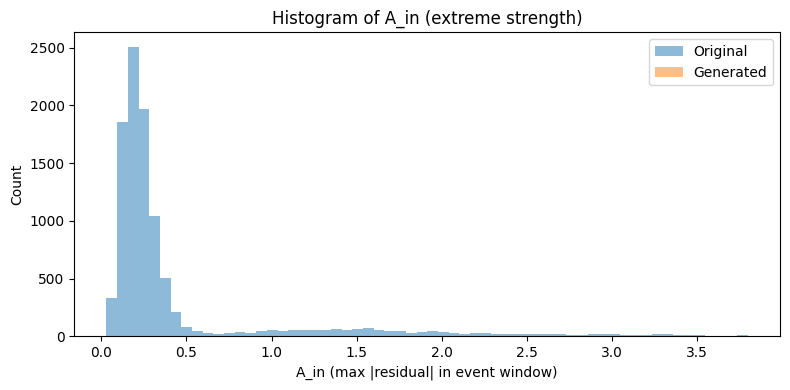

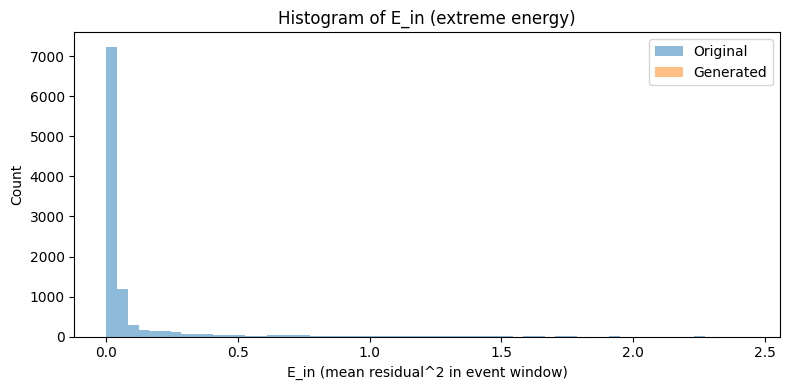

A_in quantiles:
  Original : {'q90': 1.3072300195693973, 'q95': 1.9144090354442589, 'q99': 3.11262360095978}
  Generated: {'q90': 0.3029814004898071, 'q95': 0.3346997022628784, 'q99': 0.36007434368133545}

E_in quantiles:
  Original : {'q90': 0.20154777020216014, 'q95': 0.44482836574315915, 'q99': 1.131223660707474}
  Generated: {'q90': 0.03385602124035357, 'q95': 0.04875022545456883, 'q99': 0.060665590316057214}


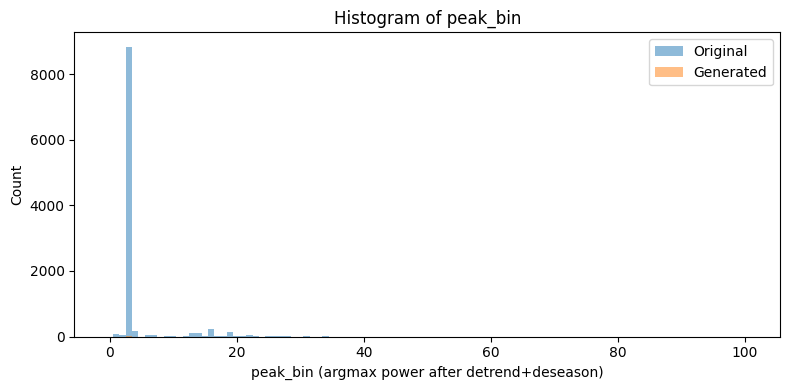

peak_bin median:
  Original : 3
  Generated: 3

peak_bin quantiles (10/50/90%):
  Original: q10=3, q50=3, q90=4
  Generated: q10=3, q50=3, q90=3

hit rate (peak in target band):
  Original : 0.02070000022649765
  Generated: 0.0


In [7]:
plot_extreme_strength_tail(out_time_ori, out_time_gen, bins=60)
print_extreme_strength_quantiles(out_time_ori, out_time_gen, qs=(0.9, 0.95, 0.99))
1111111111111111111111111111111111
plot_peakbin_distribution(out_freq_ori, out_freq_gen)
print_peakbin_median_and_hit(out_freq_ori, out_freq_gen)

## Disentangle

In [8]:
origin_norm = np.load('../../OUTPUT/toyexample/origin_data_norm_toyexample.npy')
origin_unnorm = np.load('../../OUTPUT/toyexample/origin_data_unnorm_toyexample.npy')
generate_norm = np.load('../../OUTPUT/toyexample/generate_data_norm_toyexample.npy')
generate_unnorm = np.load('../../OUTPUT/toyexample/generate_data_unnorm_toyexample.npy')

In [9]:
def plot_denoising_grid(ts, imgs, step_interval=50, include_last=True, save_path=None, reverse=True):
    ts = np.asarray(ts).astype(int)
    S, B, T, C = imgs.shape

    target_steps = list(range(int(ts.min()), int(ts.max()) + 1, step_interval))
    if include_last and (int(ts.max()) not in target_steps):
        target_steps.append(int(ts.max()))

    sel_idx = [int(np.argmin(np.abs(ts - s))) for s in target_steps]
    sel_steps = ts[sel_idx]

    # 关键：倒序显示（t 大在上）
    if reverse:
        sel_idx = sel_idx[::-1]
        sel_steps = sel_steps[::-1]

    R = len(sel_idx)
    x = np.arange(T)

    fig, axes = plt.subplots(R, B, figsize=(B * 2.0, R * 1.6), sharex=True, sharey=True)
    if R == 1:
        axes = axes[None, :]

    for r, (k, step) in enumerate(zip(sel_idx, sel_steps)):
        for b in range(B):
            y = imgs[k, b].mean(axis=-1)
            ax = axes[r, b]
            ax.plot(x, y, linewidth=1.0)
            ax.set_xticks([])
            ax.set_yticks([])
            if r == 0:
                ax.set_title(f"s{b}", fontsize=9)
        axes[r, 0].set_ylabel(f"t={int(step)}", rotation=0, labelpad=25, fontsize=9, va="center")

    fig.suptitle(f"Denoising snapshots every {step_interval} steps", y=1.02, fontsize=12)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, dpi=200, bbox_inches="tight")
    plt.show()
    return fig

In [10]:
def load_trace_npz_as_arrays(path):
    z = np.load(path, allow_pickle=False)
    ts = z["t"].astype(int)
    ts = np.sort(ts)

    imgs   = np.stack([z[f"img/{t}"]        for t in ts], axis=0)
    trends = np.stack([z[f"trend_cum/{t}"]  for t in ts], axis=0)
    seasons= np.stack([z[f"season_cum/{t}"] for t in ts], axis=0)

    return ts, imgs, trends, seasons

In [11]:
# visualize_two_distributions(origin_norm, generate_norm, method="pca")
# visualize_two_distributions(origin_norm, generate_norm, method="tsne")
# visualize_two_distributions(origin_norm, generate_norm, method="kde")

## Sample Visualization

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def trend_linear(y, enforce_nonneg_slope=True):
    y = y.astype(np.float32)   # 关键：别用 float16 进 linalg
    t = np.arange(len(y), dtype=np.float32)
    A = np.c_[t, np.ones_like(t)]
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]
    if enforce_nonneg_slope:
        a = max(a, 0.0)
    return a * t + b

def seasonality_fft_topk(residual, top_k=5):
    T = len(residual)
    spec = np.fft.rfft(residual)
    mag = np.abs(spec)
    mag[0] = 0.0  # 去 DC

    k = min(top_k, len(mag) - 1)
    idx = np.argpartition(mag, -k)[-k:]
    idx = idx[np.argsort(mag[idx])[::-1]]

    spec_sel = np.zeros_like(spec)
    spec_sel[idx] = spec[idx]
    seasonal = np.fft.irfft(spec_sel, n=T)
    return seasonal, idx, mag

def plot_random(data, num, random_state=0, top_k=5, enforce_nonneg_slope=True):
    B, T, C = data.shape
    rng = np.random.RandomState(random_state)
    idxs = rng.choice(B, size=min(num, B), replace=False)
    x = np.arange(T)

    # 1) original
    plt.figure(figsize=(10, 4))
    for i in idxs:
        y = data[i].mean(axis=1)
        plt.plot(x, y, alpha=0.9)
    plt.title("Random samples (original)")
    plt.xlabel("Time index")
    plt.ylabel("Value")
    plt.tight_layout()
    plt.show()

    # 2) trend
    plt.figure(figsize=(10, 4))
    for i in idxs:
        y = data[i].mean(axis=1)
        tr = trend_linear(y, enforce_nonneg_slope=enforce_nonneg_slope)
        plt.plot(x, tr, alpha=0.9)
    plt.title("Random samples (trend: linear increasing baseline)")
    plt.xlabel("Time index")
    plt.ylabel("Trend")
    plt.tight_layout()
    plt.show()

    # 3) seasonality curve
    plt.figure(figsize=(10, 4))
    for i in idxs:
        y = data[i].mean(axis=1)
        tr = trend_linear(y, enforce_nonneg_slope=enforce_nonneg_slope)
        r = y - tr
        seas, _, _ = seasonality_fft_topk(r, top_k=top_k)
        plt.plot(x, seas, alpha=0.9)
    plt.title(f"Random samples (seasonality: Top-{top_k} FFT after detrend)")
    plt.xlabel("Time index")
    plt.ylabel("Seasonality")
    plt.tight_layout()
    plt.show()

    # 4) show which Top-K frequencies (bins) per sample
    # rFFT bin k 对应“每个采样点的归一化频率” f = k / T（cycles/sample）
    # 若你有采样间隔 dt，可换成真实频率：f_hz = k / (T*dt)
    fig, axes = plt.subplots(len(idxs), 1, figsize=(10, 2.2 * len(idxs)), sharex=False)
    if len(idxs) == 1:
        axes = [axes]

    for ax, i in zip(axes, idxs):
        y = data[i].mean(axis=1)
        tr = trend_linear(y, enforce_nonneg_slope=enforce_nonneg_slope)
        r = y - tr

        _, bins, mag = seasonality_fft_topk(r, top_k=top_k)
        freqs = bins / T              # cycles per sample (归一化频率)
        amps = mag[bins]              # 幅度

        ax.stem(freqs, amps, basefmt=" ")
        ax.set_title(f"sample {i}: Top-{top_k} FFT bins (after detrend)")
        ax.set_xlabel("frequency (cycles/sample) = k/T")
        ax.set_ylabel("amplitude")

    plt.tight_layout()
    plt.show()


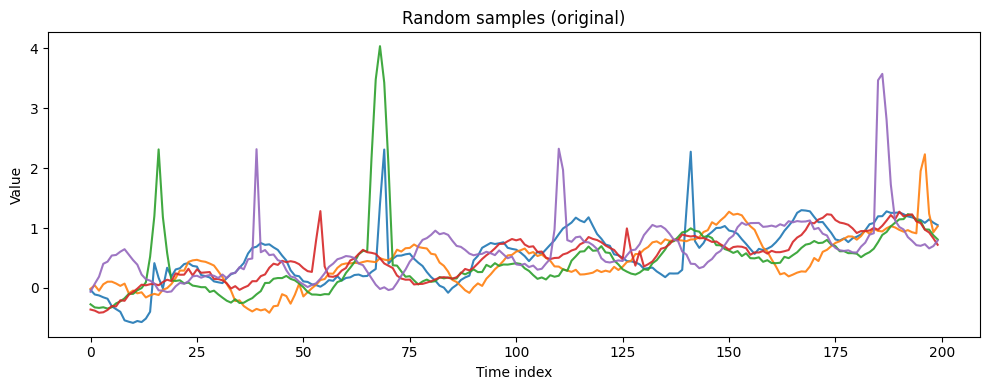

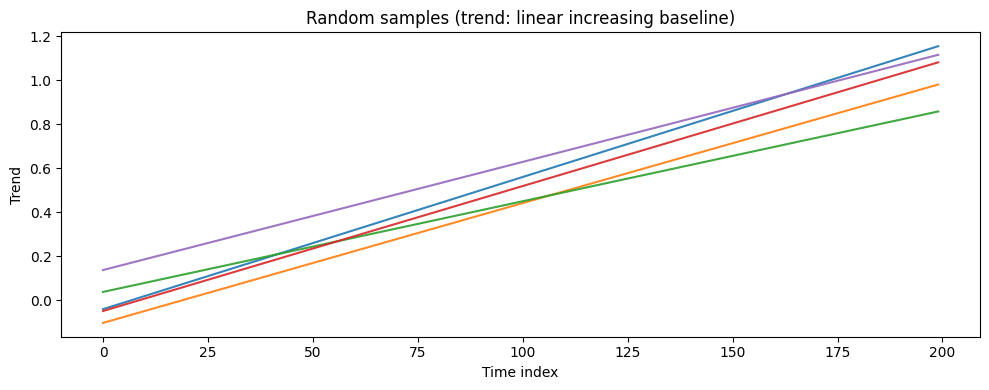

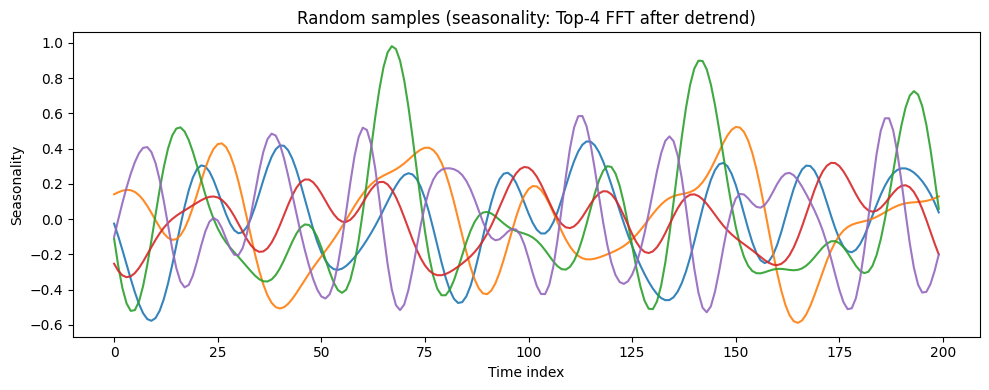

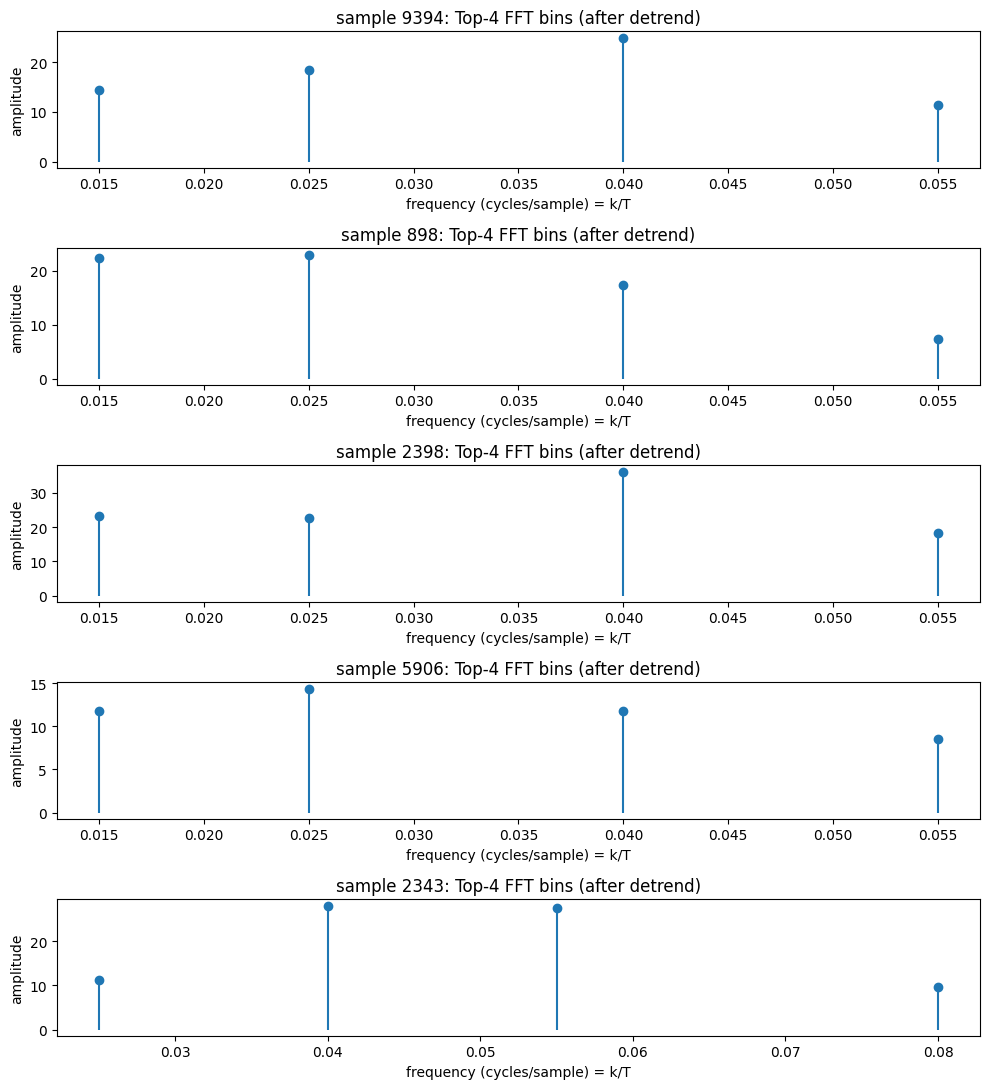

In [13]:
plot_random(origin_unnorm,num = 5,top_k = 4)

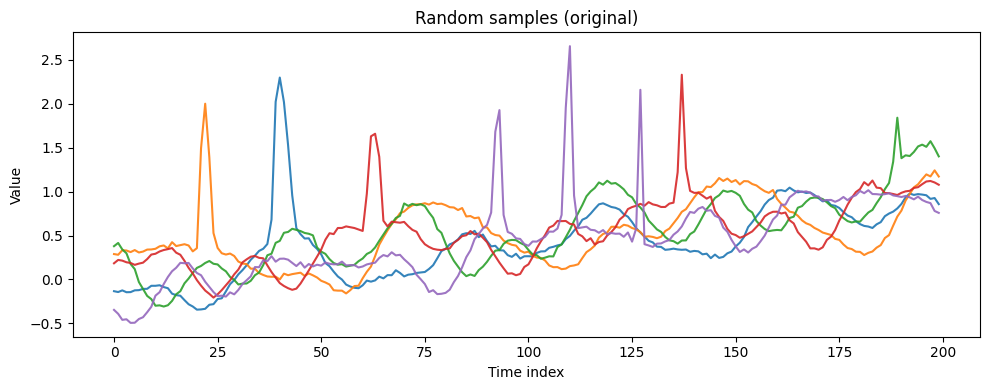

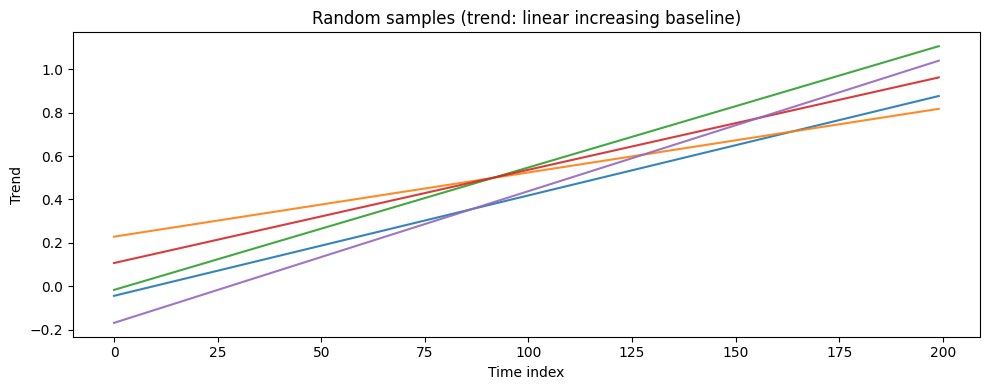

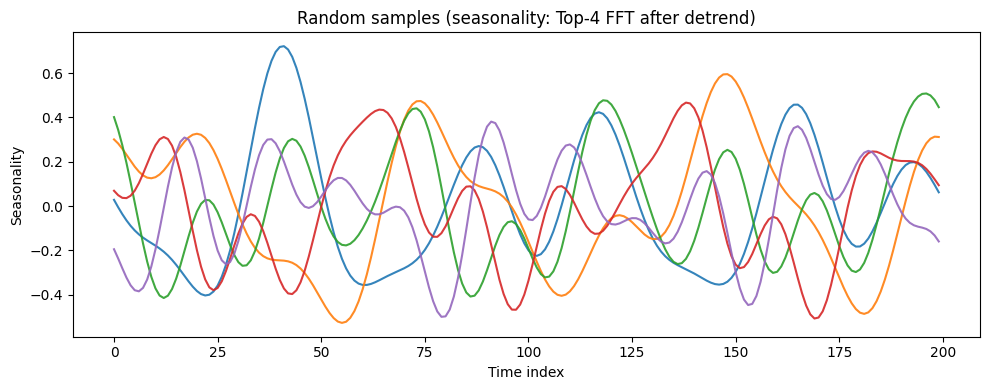

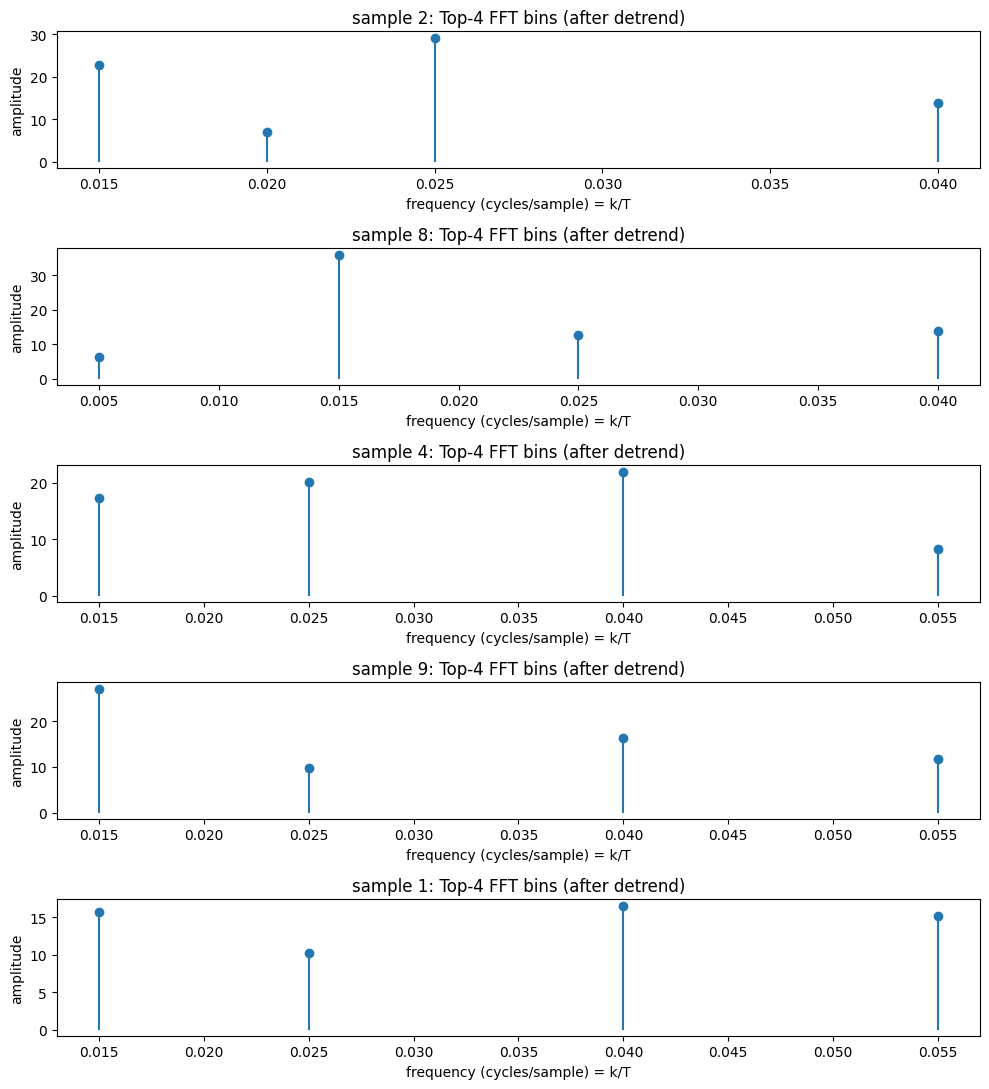

In [14]:
plot_random(generate_unnorm,num = 5,top_k = 4)

In [15]:
ts, imgs, trends, seasons = load_trace_npz_as_arrays("../../OUTPUT/toyexample/trace_toyexample.npz")

In [16]:
trends.shape

(500, 10, 2, 200, 1)

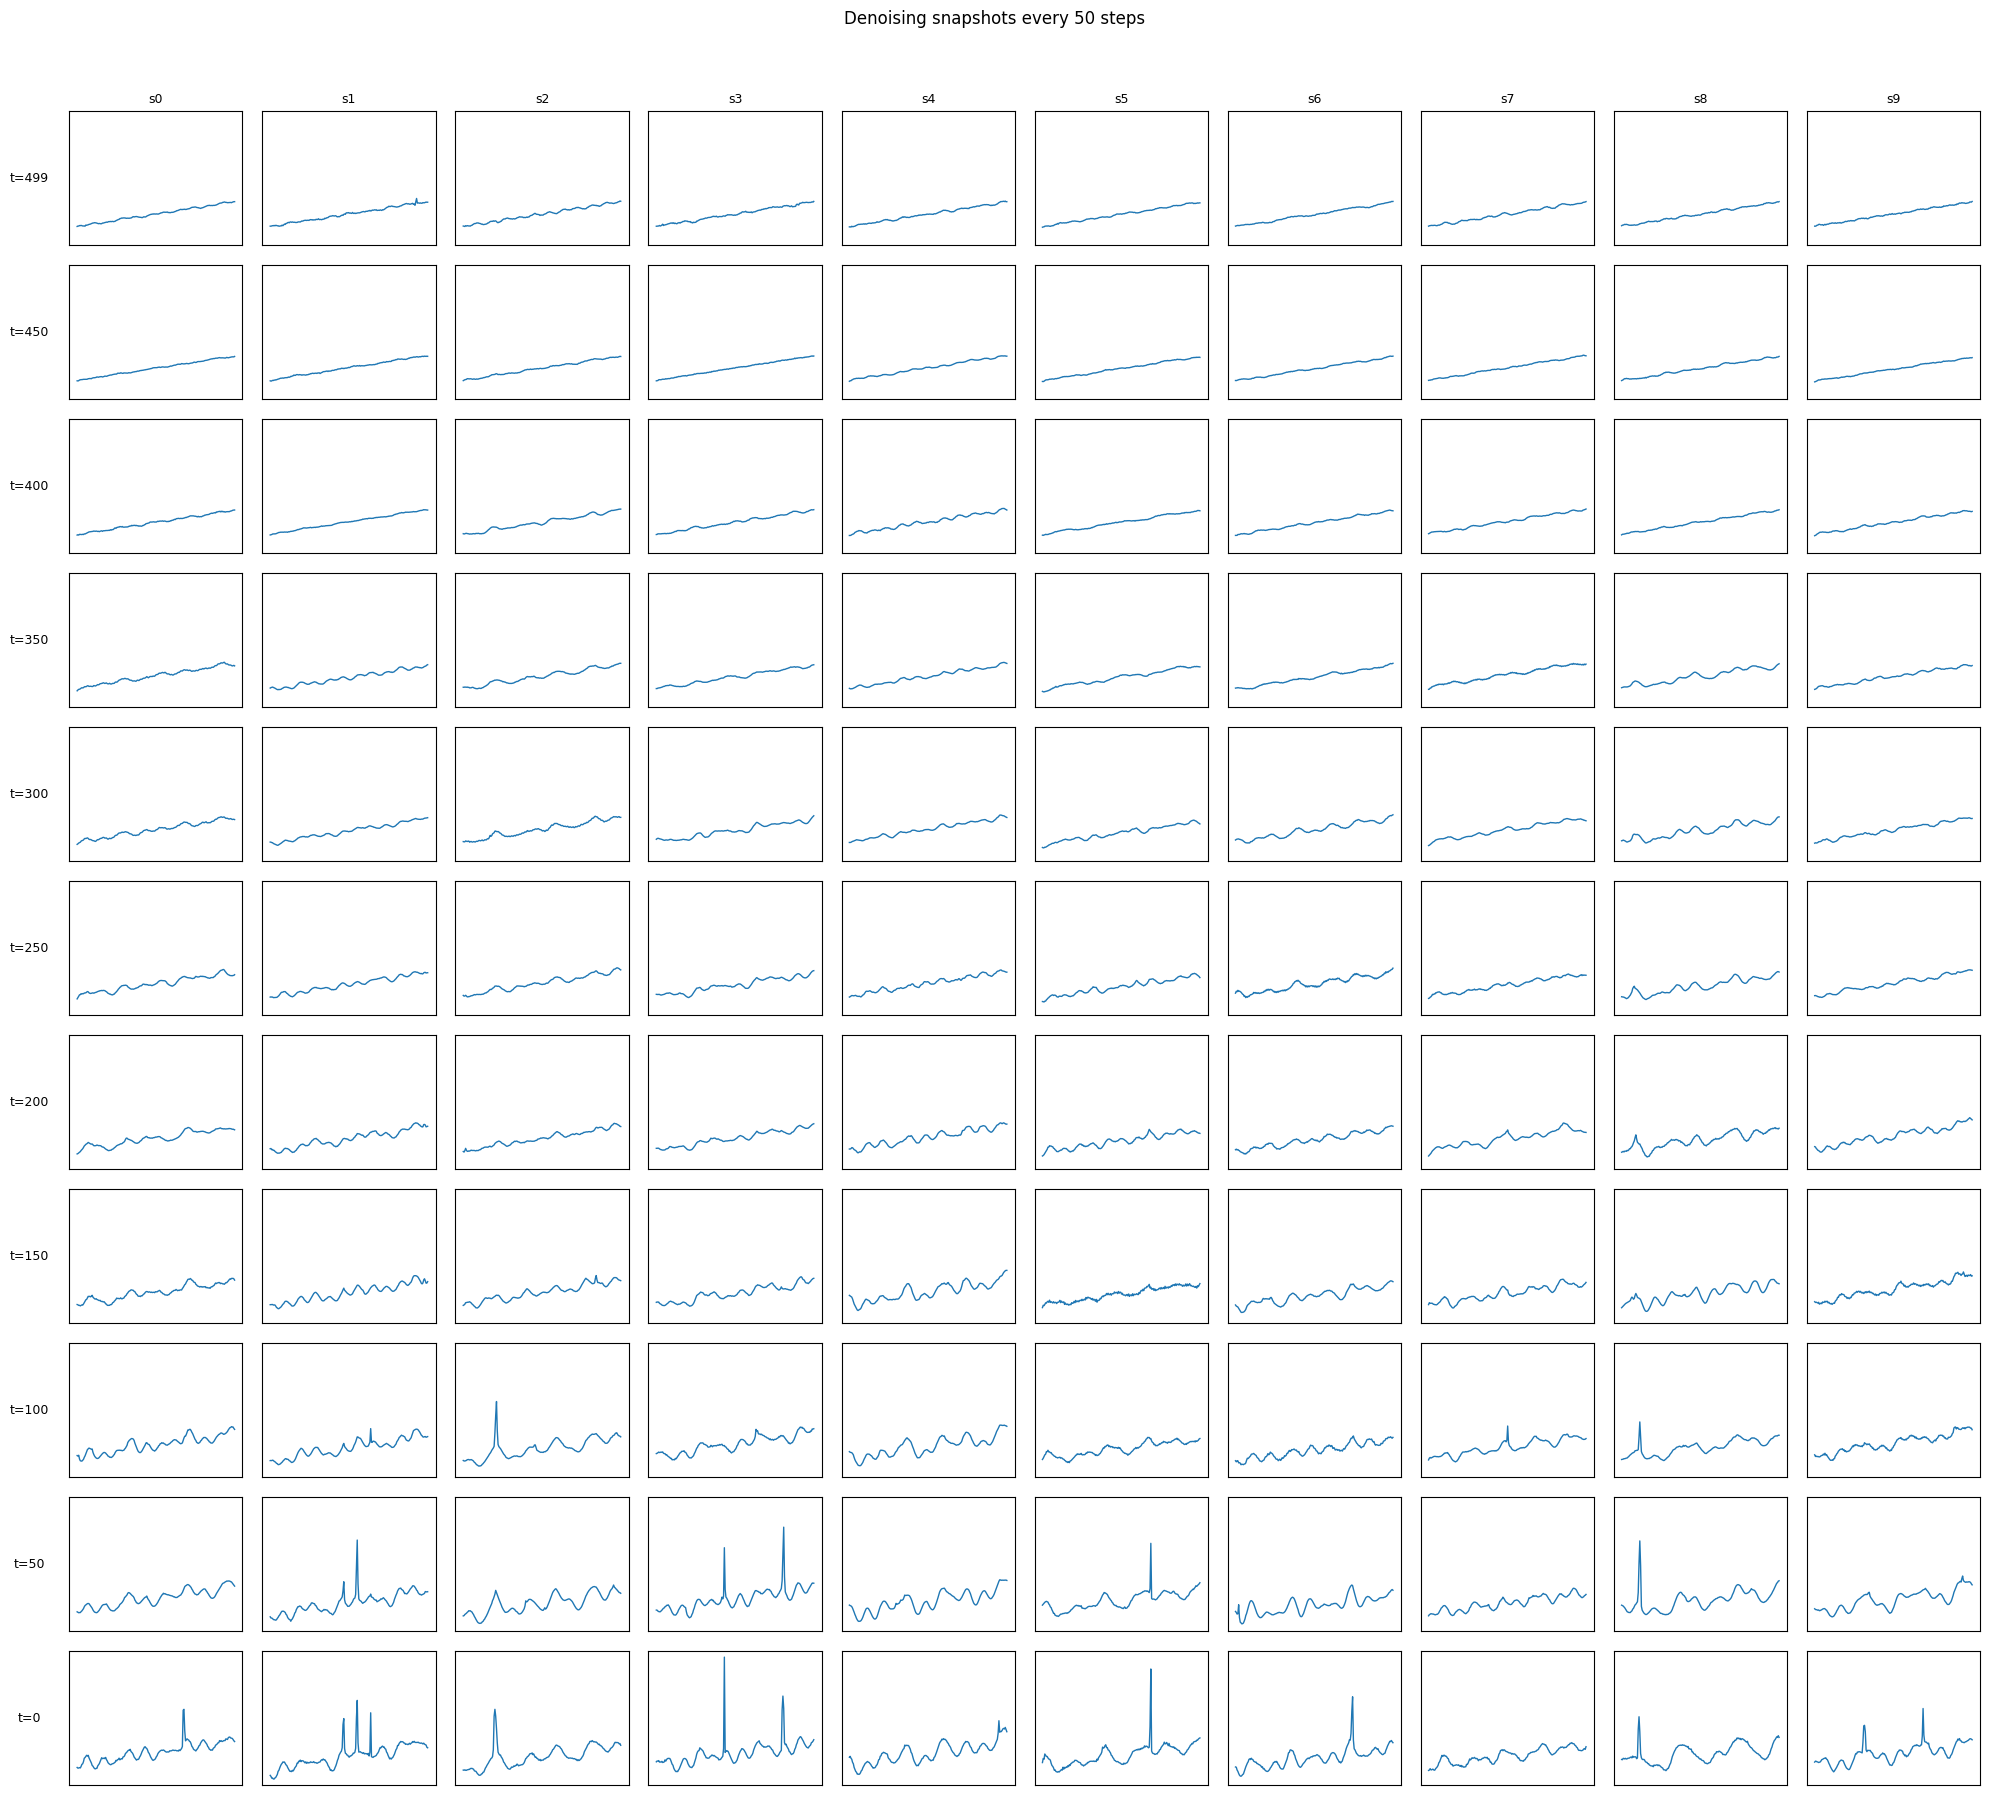

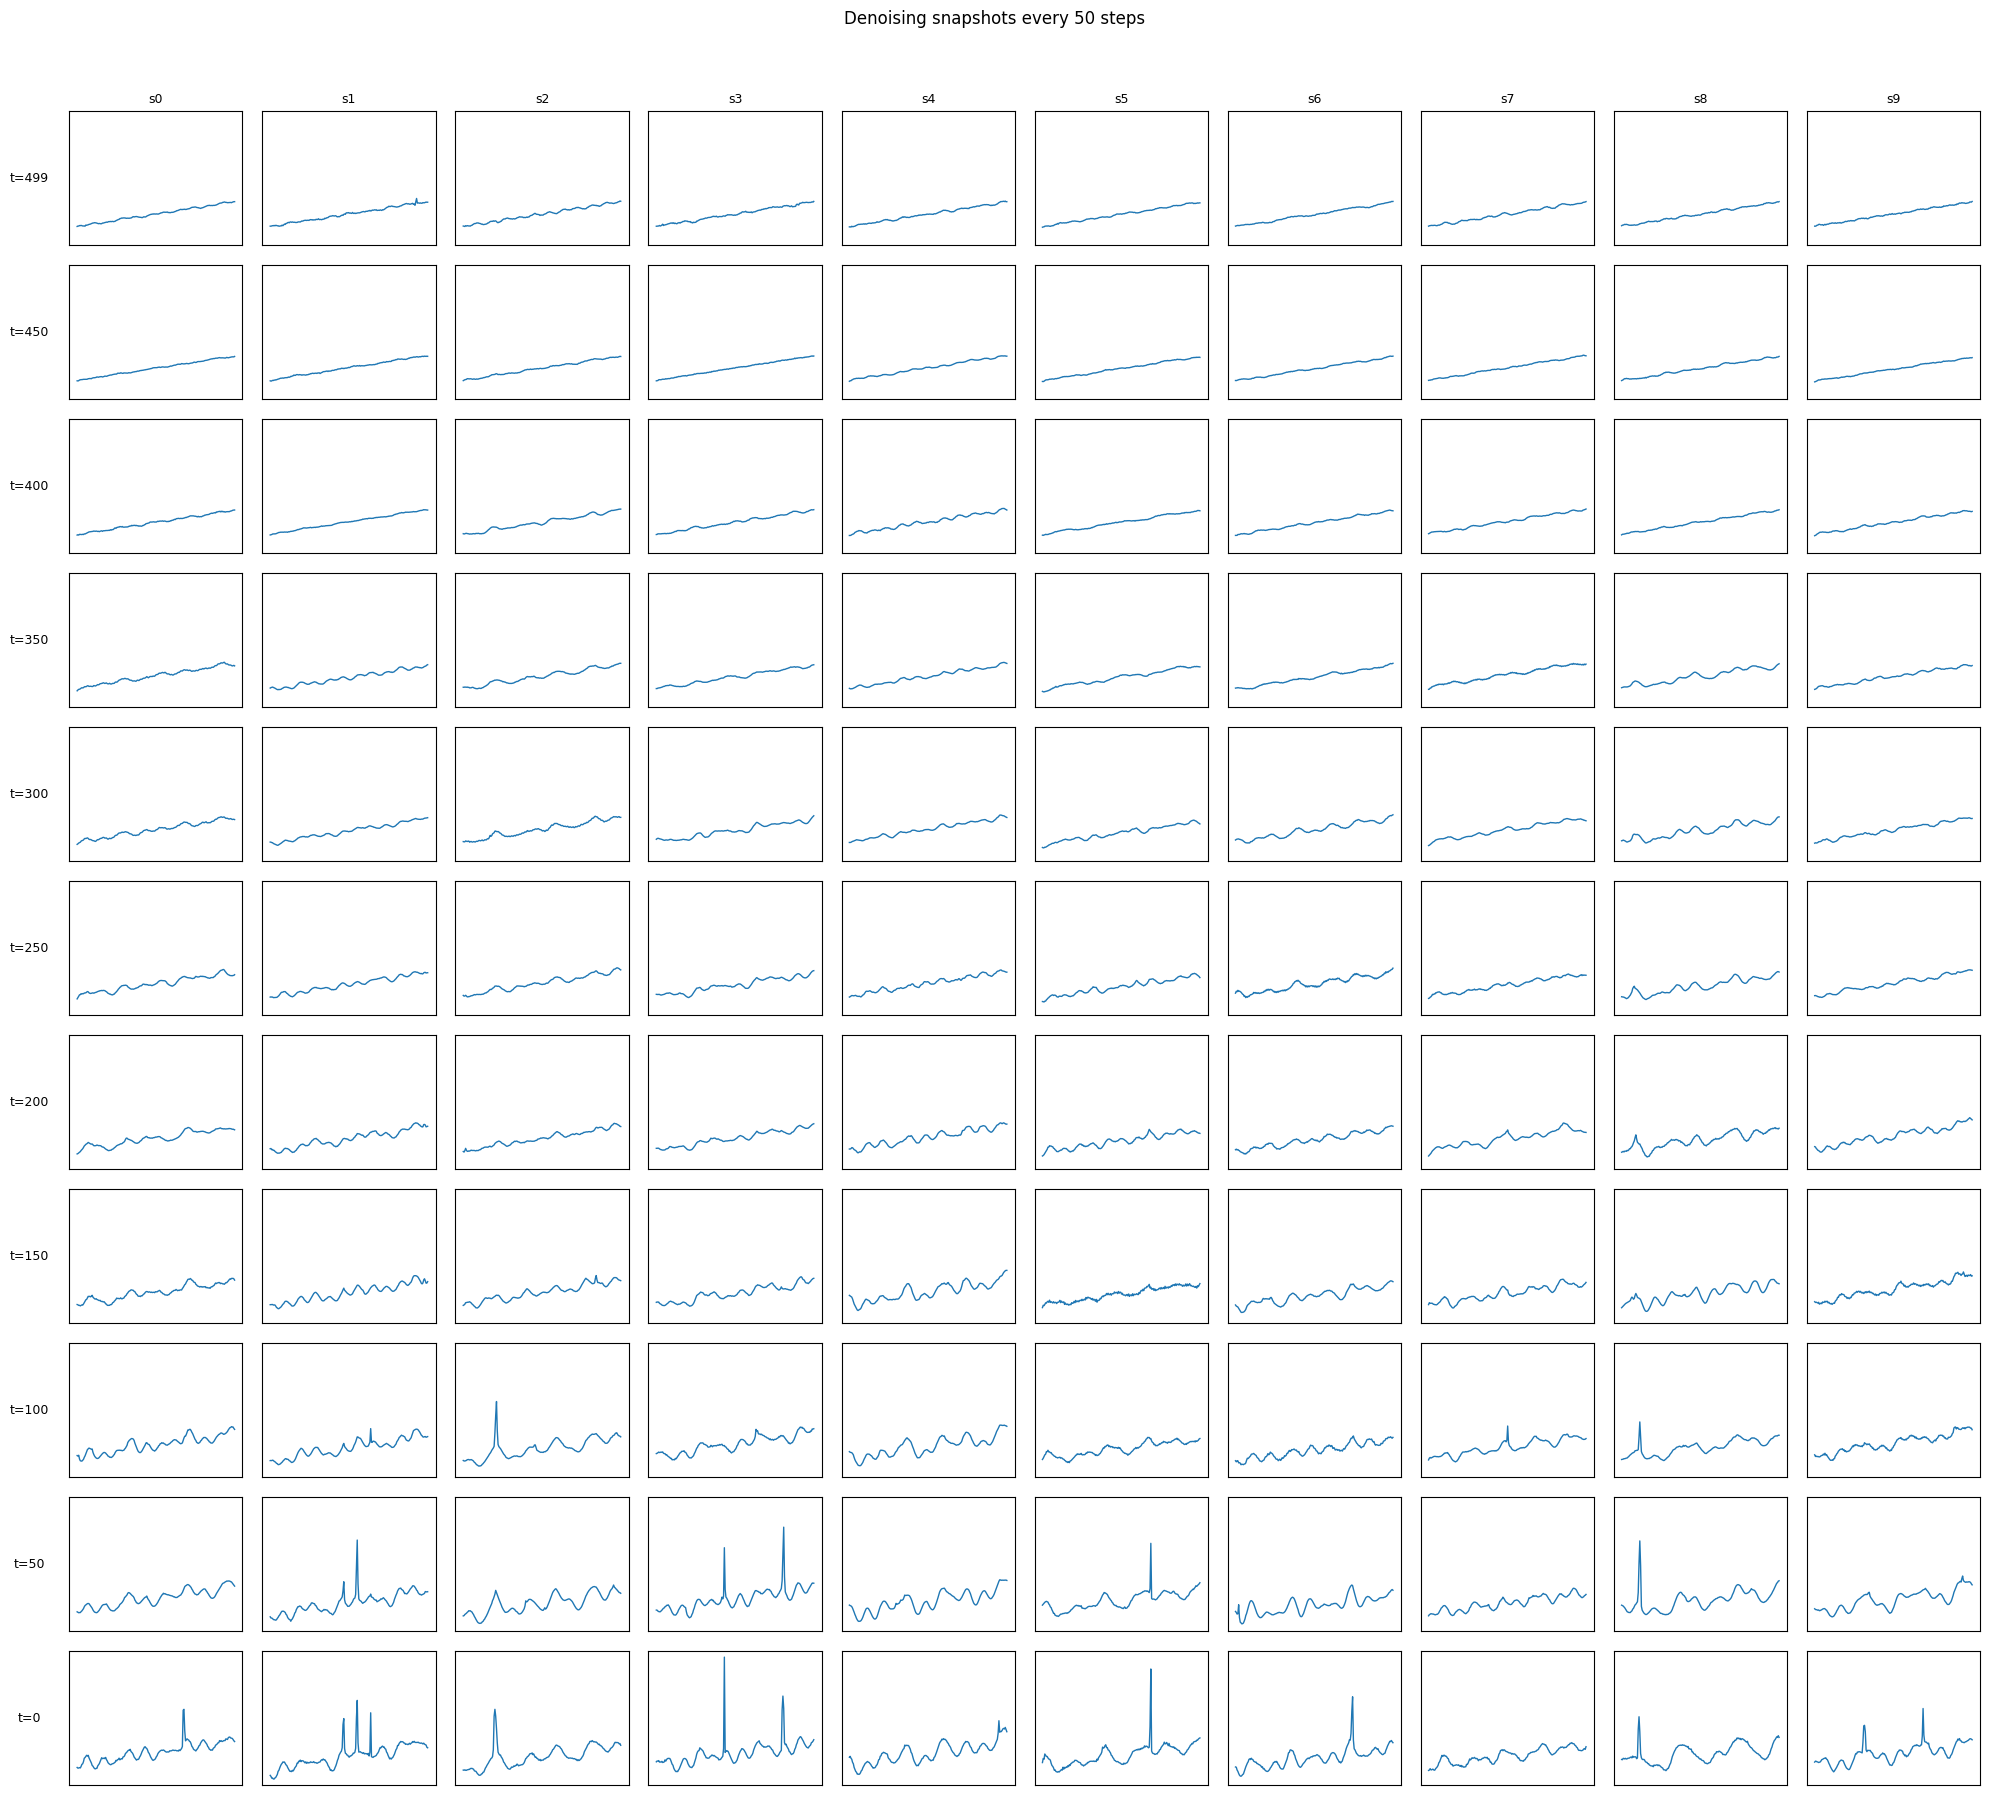

In [17]:
plot_denoising_grid(ts, imgs, step_interval=50, save_path="denoise_grid.png")